In [1]:
%matplotlib inline
from atomate.vasp.database import VaspCalcDb
import pandas as pd
from pymatgen import Structure, Element, Spin
from pymatgen.electronic_structure.plotter import BSPlotter, DosPlotter
from pymatgen.io.vasp.outputs import Vasprun, Locpot, VolumetricData
import os
import numpy as np
from math import floor
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
db_wse2_like = VaspCalcDb.from_db_file("db_WSe2_like_Ef_from_C2DB.json")   
db_wse2_Ef = VaspCalcDb.from_db_file("db_wse2_Ef.json")   
db_dk = VaspCalcDb.from_db_file("db_dk_local.json")   
db_c2db_tmdc_bglg1 = VaspCalcDb.from_db_file("db_c2db_tmdc_bglg1.json")
db_mx2_antisite_basic_aexx035 = VaspCalcDb.from_db_file('/Users/jeng-yuantsai/Research/qubit/'
                                                        'calculations/mx2_antisite_basic_aexx0.35/db.json')

In [118]:
e = db_mx2_antisite_basic_aexx035.get_eigenvals(2389)
e["1"][0][224]

[-2.4093, 1.0]

In [202]:
class SearchDB:
    def __init__(self, criteria, db):
        self.criteria = criteria
        self.db = db
#         self.key_value = {
#             "_id":0,
#             "chemsys":1,
#             "calcs_reversed.output.bandgap":1
#         }
        
    def db_sheet(self):
        host_mine = []
        for e in self.db.collection.find(self.criteria):
            entry = {}
            entry["bandgap"] = e["calcs_reversed"][0]["output"]["bandgap"]
#             entry["kpoints"] = e["calcs_reversed"][0]["input"]["kpoints"]["kpoints"][0]
#             entry["complete"] = e["calcs_reversed"][0]["completed_at"].split(" ")[0]
            entry["evac"] = max(e["calcs_reversed"][0]["output"]["locpot"]["2"])
            entry["vbm"] = e["calcs_reversed"][0]["output"]["vbm"] - entry["evac"]
            entry["cbm"] = e["calcs_reversed"][0]["output"]["cbm"] - entry["evac"]
#             entry["task_label"] = e["task_label"]
            entry["formula"] = e["formula_pretty"]
#             entry["energy"] = e["output"]["energy"]
#             entry["mag"] = e["calcs_reversed"][0]["output"]["outcar"]["total_magnetization"]
#             entry["task_id"] = e["task_id"]
#             entry["LVHAR"] = bool(e["input"]["parameters"]["LVHAR"])
#             entry["ENCUT"] = e["input"]["incar"]["ENCUT"]
            entry["nsites"] = e["nsites"]
#             entry["Lz"] = e["input"]["structure"]["lattice"]["c"]
#             entry["AEXX"] = e["input"]["parameters"]["AEXX"]
#             entry["chemsys"] = e["chemsys"]
#             entry["charge_state"] = e["charge_state"]
            entry["task_id"] = e["task_id"]
            host_mine.append(entry)
        host_mine = pd.DataFrame(host_mine).round(3)
        host_mine = host_mine.set_index("formula")
        host_mine = host_mine.loc[["MoS2", "MoSe2", "WS2", "WSe2"], :]
#         print(host_mine.to_markdown())
        return host_mine

# gw = pd.DataFrame({"gw":[2.8,2.31,2.91,2.51]}, index=["MoS2", "MoSe2", "WS2", "WSe2"])
a = SearchDB({"task_label":"hse gap", "input.parameters.AEXX":0.5, "task_label":"hse gap"}, db_wse2_like)
sheet = a.db_sheet()
sheet["gw-hse"] = [2.8,2.31,2.91,2.51] - sheet["bandgap"]
# print(sheet.to_markdown())
sheet = sheet.loc[:, ["bandgap","cbm","vbm", "gw-hse", "evac", "task_id", "nsites"]]
print(sheet.to_markdown())

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

# 1. Tabler: bulk_and_defect_k_025_filter(defect, db)

In [91]:
def bulk_and_defect_k_025_filter(defect, db):
    # db = VaspCalcDb.from_db_file("db_wse2_Ef.json")   
#     kpoints = [[-0.33333333, -0.33333333, 0.0], [0,0,0]]
    kpoints = [[0.25,0.25,0]]
    host_mine = []
#     chemsys = ["Mo-S", "Mo-Se", "Mo-Te", "S-W", "Se-W", "Te-W"]
    chemsys = ["Mo-Se"]
    fm = ["A37B71", "A26B49"] if defect else ["AB2"] #, "A26B49" A37B71
    criteria = {
                        "task_id": {"$nin": [2013]}, 
                        "chemsys": {"$in": chemsys},
                        "formula_anonymous": {"$in": fm},
                        "calcs_reversed.run_type": "HSE06",
                        "input.structure.lattice.c": {"$in": [20, 30, 40]},
                        "calcs_reversed.input.kpoints.kpoints.0": {"$in": kpoints},
                        "input.parameters.AEXX": 0.25,
                        "charge_state": {"$in": [-1,0,1]},
                        "calcs_reversed.output.outcar.total_magnetization": {"$lte": 2.1, "$gte":0}
                    }
    for e in db.collection.find(criteria):
        entry = {}
        entry["kpoints"] = e["calcs_reversed"][0]["input"]["kpoints"]["kpoints"][0]
        entry["complete"] = e["calcs_reversed"][0]["completed_at"].split(" ")[0]
        entry["evac"] = max(e["calcs_reversed"][0]["output"]["locpot"]["2"])
        entry["vbm"] = e["calcs_reversed"][0]["output"]["vbm"] 
        entry["cbm"] = e["calcs_reversed"][0]["output"]["cbm"] 
        entry["bandgap"] = e["calcs_reversed"][0]["output"]["bandgap"]
        entry["task_label"] = e["task_label"]
        entry["formula"] = e["formula_pretty"]
        entry["energy"] = e["output"]["energy"]
        entry["mag"] = e["calcs_reversed"][0]["output"]["outcar"]["total_magnetization"]
        entry["task_id"] = e["task_id"]
        entry["LVHAR"] = bool(e["input"]["parameters"]["LVHAR"])
        entry["ENCUT"] = e["input"]["incar"]["ENCUT"]
        entry["nsites"] = e["nsites"]
        entry["Lz"] = e["input"]["structure"]["lattice"]["c"]
        entry["AEXX"] = e["input"]["parameters"]["AEXX"]
        entry["chemsys"] = e["chemsys"]
        entry["charge_state"] = e["charge_state"]
        entry["task_id"] = e["task_id"]
        host_mine.append(entry)
    host_mine = pd.DataFrame(host_mine)
    host_mine = host_mine.set_index("chemsys")
#     for i in host_mine.index.unique():
#         print(host_mine.loc[i, ["charge_state"]].count())
    show = ["evac", "vbm", "cbm", "bandgap", "energy", "mag", "complete", "kpoints", "AEXX", "nsites", "Lz", "charge_state", "task_id"] 
    host_mine.loc[:, show].sort_values(["chemsys","charge_state", "Lz", "nsites"]).to_clipboard()
    return host_mine
bulk_and_defect_k_025_filter(Fa, db_wse2_like)


KeyError: "None of ['chemsys'] are in the columns"

# 2. TMD Host materials in C2DB: TMDCHostC2DB

,_id,smaxinplane,magstate,is_magnetic,cell_area,has_invsymm,folder,prototype,class,uid,...,gap_hse,efermi_hse,efermi_hse_nosoc,dosef_nosoc,ICSD_id,monolayer_doi,nkinds,structure,COD_id,diff
formula,,,,,,,,,,,,,,,,,,,,,
MoS2,5ce45be607726226f73b74d1,0.000019,NM,False,8.780007,False,/home/niflheim2/cmr/C2DB/TMD/MoS2-MoS2/nm,MoS2,TMDC-H,MoS2-MoS2-NM,...,2.087439,-4.941065,-4.976102,0.0,38401,10.1103/PhysRevLett.105.136805,2,"{'@module': 'pymatgen.core.structure', '@class...",NaN,-0.080999
MoSe2,5ce45be607726226f73b74d3,0.000075,NM,False,9.544234,False,/home/niflheim2/cmr/C2DB/TMD/MoSe2-MoS2/nm,MoS2,TMDC-H,MoSe2-MoS2-NM,...,1.804162,-4.423261,-4.449428,0.0,49800,10.1364/OE.21.004908,2,"{'@module': 'pymatgen.core.structure', '@class...",1528933.0,-0.111929
Te2Mo,5ce45be607726226f73b74d5,0.000040,NM,False,10.898057,False,/home/niflheim2/cmr/C2DB/TMD/MoTe2-MoS2/nm,MoS2,TMDC-H,MoTe2-MoS2-NM,...,1.369604,-4.135714,-4.179022,0.0,15431,10.1038/nature24043,2,"{'@module': 'pymatgen.core.structure', '@class...",NaN,-0.146619
WS2,5ce45be607726226f73b7553,0.000071,NM,False,8.790376,False,/home/niflheim2/cmr/C2DB/TMD/WS2-MoS2/nm,MoS2,TMDC-H,WS2-MoS2-NM,...,2.054929,-4.640546,-4.723526,0.0,202367,10.1021/nn503093k,2,"{'@module': 'pymatgen.core.structure', '@class...",9009145.0,-0.278206
WSe2,5ce45be607726226f73b7555,0.000012,NM,False,9.539967,False,/home/niflheim2/cmr/C2DB/TMD/WSe2-MoS2/nm,MoS2,TMDC-H,WSe2-MoS2-NM,...,1.730437,-4.167726,-4.220882,0.0,84182,10.1364/OE.21.004908,2,"{'@module': 'pymatgen.core.structure', '@class...",9012193.0,-0.310215
Te2W,5ce45be607726226f73b7557,0.000003,NM,False,10.914554,False,/home/niflheim2/cmr/C2DB/TMD/WTe2-MoS2/nm,MoS2,TMDC-H,WTe2-MoS2-NM,...,1.140864,-3.942374,-4.034439,0.0,653170,10.1038/nmat4080,2,"{'@module': 'pymatgen.core.structure', '@class...",NaN,-0.346029


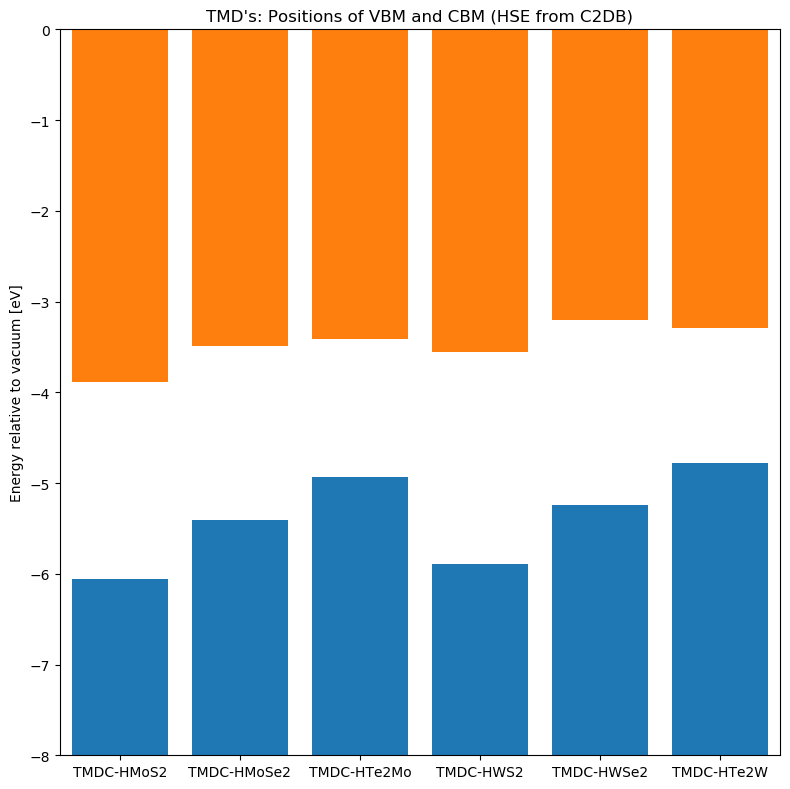

In [8]:
class TMDCHostC2DB:
    def __init__(self, db_dk=db_dk):
        self.db_dk = db_dk
        self.e_host = None
        
    def host_seraching_c2db(self):
        col_host = self.db_dk.collection
        criteria = {
            "formula":{"$in":["MoS2", "MoSe2", "MoTe2", "WS2", "WSe2", "WTe2"]}, 
            "magstate":"NM", "gap_hse":{"$gte":1}, 
            "class":{"$in":["TMDC-T", "TMDC-H", "TMDC-T'"]}, 
            "ehull":{"$lt":0.3}
        }
        df = pd.DataFrame(list(col_host.find(criteria))).set_index("formula")
        df.reindex(index=["MoS2", "MoSe2", "MoTe2", "WS2", "WSe2", "WTe2"])
        df.loc[:, "diff"] = df.loc[:, "gap_hse"] - df.loc[:, "gap_hse_nosoc"]
        df.loc[:, ["gap_hse_nosoc", "cbm_hse_nosoc", "vbm_hse_nosoc"]]
        e_host = df.rename(dict(zip(["MoS2", "MoSe2", "MoTe2", "WS2", "WSe2", "WTe2"], ["MoS2", "MoSe2", "Te2Mo", "WS2", "WSe2", "Te2W"])))
        display(e_host)
        self.e_host = e_host
        return e_host
    
    def host_plot_CB_VB(self):   
        labels = self.e_host["class"]+ self.e_host.index
        vbms = self.e_host["vbm_hse_nosoc"]
        cbms = self.e_host["cbm_hse_nosoc"]


        x = np.arange(len(vbms)) + 0.5
        emin = floor(min(vbms)) - 1.0

        # With and height in pixels
        ppi = 100
        figw = 800
        figh = 800

        fig = plt.figure(figsize=(figw / ppi, figh / ppi), dpi=ppi)
        ax = fig.add_subplot(1, 1, 1)
        ax.bar(x, np.array(vbms) - emin, bottom=emin)
        ax.bar(x, -np.array(cbms), bottom=cbms)
        ax.set_xlim(0, len(labels))
        ax.set_ylim(emin, 0)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=0, fontsize=10)

        plt.title("TMD's: Positions of VBM and CBM (HSE from C2DB)", fontsize=12)
        plt.ylabel('Energy relative to vacuum [eV]', fontsize=10)
        plt.tight_layout()
#         plt.savefig(os.path.join("/Users/jeng-yuantsai/Research/qubit/My_manuscript/WSe_2/support/c2db_TMDC_search/plt", 
#                                  "wse2_like_bulk_bd_align.eps"), img_format="eps")
        plt.show()

tmd_host = TMDCHostC2DB()
tmd_host.host_seraching_c2db()
tmd_host.host_plot_CB_VB()

# 3. My defect states and hosts: MyTmdc

In [3]:
class MyTmdc:
    def __init__(self, host_c2db, db=db_wse2_like):
        self.db = db
        self.host_c2db = host_c2db
        
    def my_tmdc_host(self):
        col = self.db.collection
        host_mine = []
        compounds = ["MoS2", "MoSe2", "Te2Mo", "WS2", "WSe2", "Te2W"]
        criteria = {
            "formula_pretty": {"$in":compounds},

        #     "formula_pretty": "Te2Mo",
        #     "calcs_reversed.run_type": "HSE06",
        #     "calcs_reversed.input.kpoints.kpoints.0": {"$nin":[[-0.333, 0.333, 0], [1,1,1], [0.25,0.25,0]]},
        #     "calcs_reversed.input.kpoints.kpoints.0": {"$in": [[1/3, 1/3, 0], [0,0,0]]},
            "nsites": {"$in":[3]},
            "task_label": "hse gap",
        #     "calcs_reversed.input.structure.lattice.c": {"$in": [20, 30, 40]},
        #     "charge_state": 0
            "input.parameters.EDIFF": {"$in":[1e-6]},
            "input.parameters.AEXX": 0.25
        }

        host_supercell = [1910, 1911, 1920, 1924, 1935, 1936]


        for e in col.find(criteria):
            entry = {}
        #     entry["kpoints"] = e["calcs_reversed"][0]["input"]["kpoints"]["kpoints"][0]
            entry["complete"] = e["calcs_reversed"][0]["completed_at"].split(" ")[0]
            entry["evac"] = max(e["calcs_reversed"][0]["output"]["locpot"]["2"])
            entry["vbm"] = e["calcs_reversed"][0]["output"]["vbm"]
            entry["cbm"] = e["calcs_reversed"][0]["output"]["cbm"]
            entry["bandgap"] = e["calcs_reversed"][0]["output"]["bandgap"]
            entry["task_label"] = e["task_label"]
            entry["formula"] = e["formula_pretty"]
            entry["energy"] = e["output"]["energy"]
            entry["mag"] = e["calcs_reversed"][0]["output"]["outcar"]["total_magnetization"]
            entry["task_id"] = e["task_id"]
            entry["LVHAR"] = bool(e["input"]["parameters"]["LVHAR"])
            entry["ENCUT"] = e["input"]["incar"]["ENCUT"]
            entry["nsites"] = e["nsites"]
            entry["Lz"] = e["input"]["structure"]["lattice"]["c"]
            entry["AEXX"] = e["input"]["parameters"]["AEXX"]
            entry["EDIFF"] = e["input"]["parameters"]["EDIFF"]
            entry["chemsys"] = e["chemsys"]
            entry["task_id"] = e["task_id"]
            host_mine.append(entry)
        host_mine = pd.DataFrame(host_mine).set_index("formula")
        host_mine.loc["WSe2", ["bandgap"]] = 2.0093
        host_mine.loc["WSe2", ["cbm"]] = 0.0271
        host_mine.loc["WSe2", ["vbm"]] = -1.9822
        host_mine = host_mine.reindex(index=["MoS2", "MoSe2", "Te2Mo", "WS2", "WSe2", "Te2W"])
        display(host_mine)
        for i in ["cbm", "vbm"]: host_mine.loc[:, i] = host_mine.loc[:, i] - host_mine.loc[:, "evac"] 
        display(host_mine.loc[:, ["vbm", "cbm", "bandgap"]])
        self.host_mine = host_mine
        return host_mine
        
    def triplet_defect_state_plot(self, filter_label, labels_in_plot, up, down, cbms, vbms):

        evac = []
        for chemsys in filter_label:
            e = self.db.collection.find_one({"task_label":"HSE_scf", "chemsys":chemsys})
            vac = max(e["calcs_reversed"][0]["output"]["locpot"]["2"])
            evac.append(vac)
        evac = np.array(evac)
         
        vbms_025 = []
        print(vbms)
        for chemsys in filter_label:
            e = self.db.collection.find_one({"task_label":"HSE_scf", "chemsys":chemsys})
            ev = self.db.get_eigenvals(e["task_id"])
            band = vbms[e["chemsys"]]
            vbms_025.append(ev[band[0]][0][band[1]][0])
        vbms_025 = np.array(vbms_025) - evac
                
        cbms_025 = []
        for chemsys in filter_label:
            e = self.db.collection.find_one({"task_label":"HSE_scf", "chemsys":chemsys})
            ev = self.db.get_eigenvals(e["task_id"])
            band = cbms[e["chemsys"]]
            cbms_025.append(ev[band[0]][0][band[1]][0])
        cbms_025 = np.array(cbms_025) - evac
        
        print(vbms_025, cbms_025)    
        x = np.arange(len(vbms_025))
        emin_025 = min(vbms_025)-0.5
        emin = emin_025
        
        ppi = 100
        figw = 800
        figh = 800

        fig = plt.figure(figsize=(figw / ppi, figh / ppi), dpi=ppi)
        ax = fig.add_subplot(1, 1, 1)

        #up
        up_band = []
        up_band_occ = []
        for chemsys, vac in zip(filter_label, evac):
            e = self.db.collection.find_one({"task_label":"HSE_scf", "chemsys":chemsys})
            up_ev = []
            up_ev_occ = []
            ev = self.db.get_eigenvals(e["task_id"])
            for band in up[e['chemsys']]:
                up_ev.append(ev["1"][0][band][0]-vac)
                if ev["1"][0][band][1] == 1:
                    up_ev_occ.append(ev["1"][0][band][0]-vac)
            up_band.append(up_ev)
            up_band_occ.append(up_ev_occ)

            
        for compound_idx in range(len(up_band)):
            ax.hlines(up_band[compound_idx], x[compound_idx]-0.4, x[compound_idx]-0.05)
        
        for occ_idx in range(len(up_band_occ)):
            for energy, pos in zip(up_band_occ[occ_idx], [0.35, 0.2]):
                ax.text(x[occ_idx]-pos, energy, "\u2b06")
        
        #dn
        dn_band = []
        dn_band_occ = []
        for chemsys, vac in zip(filter_label, evac):
            e = self.db.collection.find_one({"task_label":"HSE_scf", "chemsys":chemsys})
            ev = self.db.get_eigenvals(e["task_id"])
            dn_ev = []
            dn_ev_occ = []
            for band in down[e["chemsys"]]:
                print(band)
                if band:
                    dn_ev.append(ev["-1"][0][band][0]-vac)
                    if ev["-1"][0][band][1] == 1:
                        dn_ev_occ.append(ev["-1"][0][band][0]-vac)
            dn_band.append(dn_ev)
            dn_band_occ.append(dn_ev_occ)
            print(dn_band)
        print(dn_band)
        print(dn_band_occ)
            
        for compound_idx in range(len(dn_band)):
            ax.hlines(dn_band[compound_idx], x[compound_idx]+0.05, x[compound_idx]+0.4)
        
        for occ_idx in range(len(dn_band_occ)):
            for energy, pos in zip(dn_band_occ[occ_idx], [-0.1, 0]):
                ax.text(x[occ_idx]-pos, energy, "\u2b07")
        
        


            
        ax.bar(x, np.array(vbms_025) - emin, bottom=emin, color=plt.cm.jet(0.35))
        ax.bar(x, -np.array(cbms_025), bottom=cbms_025, color=plt.cm.jet(0.68))




#         ax.set_xlim(0, len(labels))
        ax.set_ylim(-7, -3)
        ax.set_xticks(x)
        ax.set_xticklabels(labels_in_plot, rotation=0, fontsize=10)


        plt.ylabel('Energy relative to vacuum (eV)', fontsize=20)
        plt.tight_layout()
        # plt.savefig("/Users/jeng-yuantsai/Research/qubit/My_manuscript/mx2_antisite_basic_aexx0.35/plt/mx2_antisite_basic_aexx035.eps", img_format="eps")
        plt.show()

    
    
    def singlet_defect_state_plot(self):
        labels = []
        vbms = []
        cbms = []
        labels = ["MoS2", "MoSe2", "Te2Mo", "WS2", "WSe2", "Te2W"]


        # aexx_025 = host_mine[host_mine["AEXX"] == 0.25]
        aexx_025 = self.host_mine
        vbms_025 = [aexx_025.loc[i, "vbm"] for i in labels]
        cbms_025 = [aexx_025.loc[i, "cbm"] for i in labels]

        # aexx_035 = host_mine[host_mine["AEXX"] == 0.35]
        # vbms_035 = [aexx_035.loc[i, "vbm"] for i in labels]
        # cbms_035 = [aexx_035.loc[i, "cbm"] for i in labels]


        # cbms = [-4.235740, -3.853055, -3.539939, -3.834712, -3.510149, -3.500994]
        # vbms = [-6.379840, -5.878784, -5.288739, -6.129712, -5.512449, -4.986594]

        # cbms = [-4.235740, -3.853055, -3.539939, -3.834712, -3.510149, -3.500994]
        # vbms = [-6.379840, -5.878784, -5.288739, -6.129712, -5.512449, -4.986594]


        vbms_c2db = self.host_c2db.loc[:, "vbm_hse_nosoc"]
        cbms_c2db = self.host_c2db.loc[:, "cbm_hse_nosoc"]



        x = np.arange(len(vbms_025)) + 0.5
        # emin_035 = min(vbms_035)
        emin_025 = min(vbms_025)
        emin_c2db = min(vbms_c2db)
        emin = floor(min([emin_025, emin_c2db]))
        emin = -8
        # emin_c2db = floor(min(vbms_c2db)) - 1.0
        # With and height in pixels
        ppi = 100
        figw = 800
        figh = 800

        fig = plt.figure(figsize=(figw / ppi, figh / ppi), dpi=ppi)
        ax = fig.add_subplot(1, 1, 1)






        #up
        ax.hlines([-3.596, -2.831, -2.791, -3.464, -2.762, 0.213], x-0.4, x-0.05)
        ax.hlines([-3.971, -2.860, -2.840, -3.522, -3.105, -1.842], x-0.4, x-0.05)
        ax.hlines([-4.009, -3.080, -3.588, -3.667, -3.595, -2.516], x-0.4, x-0.05)
        ax.hlines([-4.113, -3.796, -3.807, -3.826, -3.701, -2.516], x-0.4, x-0.05)
        ax.hlines([-5.912, -5.258, -4.466, -5.250, -4.578, -4.182], x-0.4, x-0.05)
        for X, Y in zip(x,[-5.912, -5.258, -4.466, -5.25, -4.578, -4.182]): 
            ax.text(X-0.3, Y, "\u2b06")


        #dn
        ax.hlines([-3.831, -2.865, -2.782, -2.995, -2.583, 0.214], x+0.05, x+0.4)
        ax.hlines([-3.937, -3.080, -2.815, -3.446, -2.69, -1.842], x+0.05, x+0.4)
        ax.hlines([-4.012, -3.427, -3.601, -3.673, -3.547, -2.516], x+0.05, x+0.4)
        ax.hlines([-4.117, -3.807, -3.658, -3.822, -3.775, -2.516], x+0.05, x+0.4)
        ax.hlines([-5.852, -5.264, -4.813, -5.294, -4.691, -4.182], x+0.05, x+0.4)
        for X, Y in zip(x,[-5.852, -5.264, -4.813, -5.294, -4.691, -4.182]): 
            ax.text(X+0.2, Y, "\u2b07")
        # for X, Y in zip(x,[-6.445, -5.809, -7.5, -6.078, -5.782, -5.522]): 
        #     ax.text(X+0.3, Y, "\u2b07")



        #occupied arrows






        # ax.bar(x, np.array(vbms_035) - emin, bottom=emin, label="vbm_0.35")
        # ax.bar(x, -np.array(cbms_035), bottom=cbms_035, label="cbm_0.35")

        # plot bars
        # ax.bar(x, np.array(vbms_c2db) - emin, bottom=emin, label="vbm_c2db")
        ax.bar(x, np.array(vbms_025) - emin, bottom=emin, label="vbm")
        ax.bar(x, -np.array(cbms_025), bottom=cbms_025, label="cbm")
        # ax.bar(x, -np.array(cbms_c2db), bottom=cbms_c2db, label="cbm_c2db")




        ax.set_xlim(0, len(labels))
        ax.set_ylim(emin, 0)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=0, fontsize=10)

        ax.legend(loc="upper right")

        plt.title("TMD's chalcogen antisite: Singlet Defect States/ Positions of VBM and CBM", fontsize=12)
        plt.ylabel('Energy relative to vacuum [eV]', fontsize=10)
        plt.tight_layout()
#         plt.savefig(os.path.join("/Users/jeng-yuantsai/Research/qubit/My_manuscript/WSe_2/support/c2db_TMDC_search/plt", 
#                                  "wse2_like_sing_defect_align_0.25.eps"), img_format="eps")
        plt.show()

    def transistion_levels(self, labels_in_plot, labels):
        vbms = []
        cbms = []



        display(self.host_c2db["cbm_hse_nosoc"]-self.host_mine["cbm"])



        # aexx_025 = host_mine[host_mine["AEXX"] == 0.25]
        aexx_025 = self.host_mine
        vbms_025 = [aexx_025.loc[i, "vbm"] for i in labels]
        cbms_025 = [aexx_025.loc[i, "cbm"] for i in labels]

        # aexx_035 = host_mine[host_mine["AEXX"] == 0.35]
        # vbms_035 = [aexx_035.loc[i, "vbm"] for i in labels]
        # cbms_035 = [aexx_035.loc[i, "cbm"] for i in labels]


        # cbms = [-4.235740, -3.853055, -3.539939, -3.834712, -3.510149, -3.500994]
        # vbms = [-6.379840, -5.878784, -5.288739, -6.129712, -5.512449, -4.986594]

        # cbms = [-4.235740, -3.853055, -3.539939, -3.834712, -3.510149, -3.500994]
        # vbms = [-6.379840, -5.878784, -5.288739, -6.129712, -5.512449, -4.986594]


        vbms_c2db = self.host_c2db.loc[:, "vbm_hse_nosoc"]
        cbms_c2db = self.host_c2db.loc[:, "cbm_hse_nosoc"]



        x = np.arange(len(vbms_025)) + 0.5
        # emin_035 = min(vbms_035)
        emin_025 = min(vbms_025)
        emin_c2db = min(vbms_c2db)
        emin = floor(min([emin_025, emin_c2db]))
        emin = -8
        # emin_c2db = floor(min(vbms_c2db)) - 1.0
        # With and height in pixels
        ppi = 100
        figw = 800
        figh = 800

        fig = plt.figure(figsize=(figw / ppi, figh / ppi), dpi=ppi)
        ax = fig.add_subplot(1, 1, 1)


        ax.hlines(np.array([0.405, 0.372, 0.263, 0.721, 0.667, 0.534])+np.array(vbms_025), x-0.4, x+0.4)
        ax.hlines(np.array([1.522, 1.219, 0.843, 1.841, 1.683, 0.862])+np.array(vbms_025), x-0.4, x+0.4)


        # ax.hlines(np.array([0.405, 0.372, 0.263, 0.721, 0.534])+np.array(vbms_025), x-0.4, x+0.4)
        # ax.hlines(np.array([1.522, 1.219, 0.843, 1.841, 0.862])+np.array(vbms_025), x-0.4, x+0.4)

        for X, Y in zip(x,np.array([0.405, 0.372, 0.263, 0.721, 0.534])+np.array(vbms_025)): 
            ax.text(X-0.35, Y+0.1, "(+/0) {:.2f}".format(Y))
        for X, Y in zip(x,np.array([1.522, 1.219, 0.843, 1.841, 0.862])+np.array(vbms_025)): 
            ax.text(X-0.35, Y+0.1, "(0/-) {:.2f}".format(Y))


        # plot bars
        # ax.bar(x, np.array(vbms_c2db) - emin, bottom=emin, label="vbm_c2db")
        ax.bar(x, np.array(vbms_025) - emin, bottom=emin, label="vbm", color=plt.cm.jet(0.35))
        ax.bar(x, -np.array(cbms_025), bottom=cbms_025, label="cbm", color=plt.cm.jet(0.68))
        # ax.bar(x, -np.array(cbms_c2db), bottom=cbms_c2db, label="cbm_c2db")




        ax.set_xlim(0, len(labels))
        ax.set_ylim(emin, 0)
#         ax.set_ylim(-7, -3)
        ax.set_xticks(x)
        ax.set_xticklabels(labels_in_plot, rotation=0, fontsize=10)

#         ax.legend(loc="upper right")

#         plt.title("Defect transition levels (eV)", fontsize=12)
        plt.ylabel("$\epsilon(q/q')$ Transition levels (eV)", fontsize=20)
        plt.tight_layout()
        plt.savefig(os.path.join("/Users/jeng-yuantsai/Research/qubit/My_manuscript/WSe_2/support/c2db_TMDC_search/plt/up-to-date", 
                                 "mx2_transition_levels_0.25.eps"), img_format="eps")
        plt.show()
    
    def compare_host_mine_c2db(self):
        bg_hse_comparison = pd.DataFrame()
        bg_hse_comparison["bg_hse"] = self.host_mine["bandgap"]
        bg_hse_comparison["bg_hse_nosoc_C2DB"] = self.host_c2db["gap_hse_nosoc"]
        bg_hse_comparison["bg_diff"] = bg_hse_comparison["bg_hse"].subtract(bg_hse_comparison["bg_hse_nosoc_C2DB"])
        bg_hse_comparison["cbm"] = self.host_mine["cbm"]
        bg_hse_comparison["cbm_C2DB"] = self.host_c2db["cbm_hse_nosoc"]
        bg_hse_comparison["cbm_diff"] = bg_hse_comparison["cbm"].subtract(bg_hse_comparison["cbm_C2DB"])
        bg_hse_comparison["vbm"] = self.host_mine["vbm"]
        bg_hse_comparison["vbm_C2DB"] = self.host_c2db["vbm_hse_nosoc"]
        bg_hse_comparison["vbm_diff"] = bg_hse_comparison["vbm"].subtract(bg_hse_comparison["vbm_C2DB"])
        bg_hse_comparison["task_id"] = self.host_mine["task_id"]
        bg_hse_comparison["task_id_C2DB"] = self.host_c2db["uid"]
        bg_hse_comparison["evac_c2db"] = self.host_c2db["evac"]
        bg_hse_comparison.round(3)
        bg_hse_comparison.loc[:, ["cbm_diff", "vbm_diff", "bg_diff"]]
        display(bg_hse_comparison)
#         bg_hse_comparison.to_clipboard()
        
a = MyTmdc(host_c2db=None, db=db_mx2_antisite_basic_aexx035)
filter_labels = ["S-W", "Se-W", "Te-W", "Mo-S", "Mo-Se", "Mo-Te"]
labels_in_plot = ["${W_{S}}^0$", "${W_{Se}}^0$", "${W_{Te}}^0$", "${Mo_{S}}^0$", "${Mo_{Se}}^0$", "${Mo_{Te}}^0$"]
# a.triplet_defect_state_plot(filter_labels, labels_in_plot, {"S-W":[224,225,226],"Se-W":[224,225,226],"Te-W":[224,225,226],"Mo-S":[302,303,304],"Mo-Se":[302,303,304],"Mo-Te":[302,303,304]},
#                             {"S-W":[None],"Se-W":[None],"Te-W":[224, 225],"Mo-S":[None],"Mo-Se":[None],"Mo-Te":[302,303]},
#                             dict(zip(filter_labels, [("1", 227), ("1", 227), ("1", 227), ("1", 305), ("1", 305),("1", 305)])),
#                             dict(zip(filter_labels, [("1", 223), ("1", 223), ("1", 223), ("1", 301), ("1", 301),("1", 301)]))
#                            )
a.triplet_defect_state_plot(labels_in_plot=labels_in_plot, labels=filter_labels, up=up, down=dn, up_occ=up_occ, down_occ=dn_occ)
# a.singlet_defect_state_plot()
# a.transistion_levels(labels_in_plot=labels_in_plot, labels=filter_labels)
# a.compare_host_mine_c2db()

NameError: name 'up' is not defined

# 4 . Anion Antisite Discovery in C2DB: AnionAntisiteDiscovery

In [10]:
class AnionAntisiteDiscovery:
    def __init__(self, db=db_c2db_tmdc_bglg1):
        self.db = db
#         self.e_host = TMDC_host_C2DB().host_seraching_c2db()
        
    def status_anion_antisite_discovery(self):
        col = self.db.collection
        sheet = []
        path = "/Users/jeng-yuantsai/Research/qubit/My_manuscript/WSe_2/support/c2db_TMDC_search/c2db_TMD_triplet_structures"
        filter_wse2_like = {
            "chemsys": {"$nin":["Cr-S", "Cr-Se", "Cr-Te", "Mo-S", "Mo-Se", "Mo-Te", "S-W", "Se-W", "Te-W"]},
            "task_id": {"$nin":[]}
        }
        for e in col.find(filter_wse2_like):#\{"calcs_reversed.output.outcar.total_magnetization": {"$gte":1.9}}):    
            if "HSE_scf" in e["task_label"]: 
        #         Structure.from_dict(e["input"]["structure"]).to("poscar", os.path.join(path, "{}_{}.vasp".format( e["task_id"], e["task_label"])))
                entry = {}
#                 for i in list(self.e_host):
#                     if Structure.from_dict(i["structure"]).composition.elements == Structure.from_dict(e["input"]["structure"]).composition.elements:
#                         entry["host_band_gap_hse"] = i["gap_hse"]
                entry["nupdown_set"] = e["nupdown_set"]
                entry["spacegroup"] = e["output"]["spacegroup"]["symbol"]
                entry["task_label"] = e["task_label"]
                entry["formula"] = e["formula_pretty"]
                entry["energy"] = e["output"]["energy"]
                entry["mag"] = e["calcs_reversed"][0]["output"]["outcar"]["total_magnetization"]
                entry["task_id"] = e["task_id"]
                entry["LVHAR"] = bool(e["input"]["parameters"]["LVHAR"])
                entry["ENCUT"] = e["input"]["incar"]["ENCUT"]
                entry["nsites"] = e["nsites"]
                entry["Lz"] = e["input"]["structure"]["lattice"]["c"]
                entry["AEXX"] = e["input"]["parameters"]["AEXX"]

                if entry["LVHAR"] is True:
                    entry["evac"] = max(e["calcs_reversed"][0]["output"]["locpot"]["2"])
                else:
                    entry["evac"] = None
                sheet.append(entry)
        display(pd.DataFrame(sheet).sort_values(["formula", "mag"]))
    
    def table_my_MX2_X_antisite(self):
        def table(defect, task_id):
        #     kpoints = [[-0.33333333, -0.33333333, 0.0], [0,0,0]]
        #     kpoints = [[0.25,0.25,0]]
            kpoints = [[1,1,1]]
        #     kpoints = [[0.21407, 0.21407, 0], [0.0474, 0.0474, 0]]
            host_mine = []
            chemsys = ["Mo-S", "Mo-Se", "Mo-Te", "S-W", "Se-W", "Te-W"]
            a = "A26B49"
            fm = ["A37B71", a] if defect else ["AB2"]
            criteria = {
                                "chemsys": {"$in": chemsys},
                                "formula_anonymous": {"$in": fm},
        #                         "calcs_reversed.run_type": "HSE06",
                                "input.structure.lattice.c": {"$in": [20]},
        #                         "calcs_reversed.input.kpoints.kpoints.0": {"$in": kpoints},
                                "input.parameters.AEXX": 0.25,
                                "charge_state": {"$in": [-1, 0 ,1]},
                                "nsites": {"$in":[75]}, 
                                "task_id": {"$in":task_id}
                            }
            for e in self.db.collection.find(criteria):
                entry = {}
                st = Structure.from_dict(e["calcs_reversed"][0]["input"]["structure"])
                if "Te" in e["chemsys"]:
                    entry["M-M (Å)"] = "{:.3f}, {:.3f}, {:.3f}".format(
                        st.get_distance(74,55), 
                        st.get_distance(74,54),
                        st.get_distance(74,49),
                    )
                    entry["M-X (Å)"] = "{:.3f}".format(st.get_distance(74,24))
                else:
                    entry["M-M (Å)"] = "{:.3f}, {:.3f}, {:.3f}".format(
                        st.get_distance(25,6), 
                        st.get_distance(25,0),
                        st.get_distance(25,5),
                    )
                    entry["M-X (Å)"] = "{:.3f}".format(st.get_distance(25,50))
                entry["kpoints"] = e["calcs_reversed"][0]["input"]["kpoints"]["kpoints"][0]
                entry["dir"] = e["calcs_reversed"][0]["dir_name"]
                entry["complete"] = e["calcs_reversed"][0]["completed_at"].split(" ")[0]
                entry["evac"] = max(e["calcs_reversed"][0]["output"]["locpot"]["2"])
                entry["vbm"] = e["calcs_reversed"][0]["output"]["vbm"]
                entry["cbm"] = e["calcs_reversed"][0]["output"]["cbm"]
                entry["Band Gap (eV)"] = "{:.3f}".format(e["calcs_reversed"][0]["output"]["bandgap"])
                entry["task_label"] = e["task_label"]
                entry["Compound"] = e["formula_pretty"]
                entry["energy"] = e["output"]["energy"]
                entry["task_id"] = e["task_id"]
                entry["LVHAR"] = bool(e["input"]["parameters"]["LVHAR"])
                entry["ENCUT"] = e["input"]["incar"]["ENCUT"]
                entry["nsites"] = e["nsites"]
                entry["Lz"] = e["input"]["structure"]["lattice"]["c"]
                entry["AEXX"] = e["input"]["parameters"]["AEXX"]
                entry["chemsys"] = e["chemsys"]
                entry["charge_state"] = e["charge_state"]
                entry["task_id"] = e["task_id"]
                entry["magmom"] = e["calcs_reversed"][0]["output"]["outcar"]["total_magnetization"]
                entry["space group"] = e["output"]["spacegroup"]["symbol"]
                entry["lattice"] = [e["input"]["structure"]["lattice"][i] for i in ["a", "b", "c"]]
                host_mine.append(entry)
            host_mine = pd.DataFrame(host_mine)
            host_mine = host_mine.set_index("chemsys")
            return host_mine
        
        trip = table(True, [882, 895, 935, 902, 1018, 1036])
        # trip = trip.loc[:, ["M-M (Å)", "M-X (Å)", "space group", "task_id"]]
        trip = trip.rename({"energy":"triplet energy"}, axis="columns")
        sing = table(True, [898, 900, 936, 905, 1032, 893])
        sing = sing.rename({"energy":"singlet energy"}, axis="columns")
        # sing = sing.loc[: ,["M-M (Å)", "M-X (Å)"]]
        d = pd.concat([trip.loc[:, ["magmom", "evac", "lattice","kpoints", "M-M (Å)", "M-X (Å)", "triplet energy", "task_id", "space group"]], 
                       sing.loc[:, ["mgamom", "evac", "lattice", "kpoints", "M-M (Å)", "M-X (Å)", "singlet energy", "task_id", "space group"]]],  axis=1)
        d["\u0394E (eV)"] = d["triplet energy"] - d["singlet energy"]
        d.to_clipboard()
        display(d)
        # dg = pd.concat([trip, energy_diff], axis=1)
        # dg.rename({"energy": "\u0394E (eV)"}, axis="columns")

a = AnionAntisiteDiscovery()
a.status_anion_antisite_discovery()
a.table_my_MX2_X_antisite()

,nupdown_set,spacegroup,task_label,formula,energy,mag,task_id,LVHAR,ENCUT,nsites,Lz,AEXX,evac
29,-1,Pm,Fe2S4:0:G:HSE_scf,Fe31S59,-678.912250,3.999994e+00,1151,True,520.0,90,20.0,0.25,3.413991
3,-1,Pm,Fe2S4:0:G:HSE_scf,Fe31S59,-676.452980,5.999999e+00,916,True,520.0,90,20.0,0.25,3.405250
31,-1,Pm,Fe2Se4:0:G:HSE_scf,Fe31Se59,-630.002398,6.000001e+00,1162,True,520.0,90,20.0,0.25,3.158085
4,-1,P1,Fe2Se4:0:G:HSE_scf,Fe31Se59,-627.724497,7.600000e+01,919,True,520.0,90,20.0,0.25,3.200754
14,2,Cm,HfS2:0:k:HSE_scf,Hf26S49,-675.703385,2.000000e+00,949,True,520.0,75,20.0,0.25,2.905757
16,2,P1,HfS2:0:k:HSE_scf,Hf26S49,-661.373478,2.000000e+00,952,True,520.0,75,20.0,0.25,3.056492
15,2,Cm,HfSe2:0:k:HSE_scf,Hf26Se49,-621.426052,2.000000e+00,950,True,520.0,75,20.0,0.25,2.757927
17,2,P1,HfSe2:0:k:HSE_scf,Hf26Se49,-610.007347,2.000000e+00,953,True,520.0,75,20.0,0.25,2.895078
33,-1,Pm,Os2O4:0:G:HSE_scf,Os31O59,-875.498751,-2.000000e+00,1180,True,520.0,90,20.0,0.25,2.721021
32,-1,Pm,Os2O4:0:G:HSE_scf,Os31O59,-874.700877,0.000000e+00,1174,True,520.0,90,20.0,0.25,2.707137


KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

# 5. Bandstructures of WSe2-like primitive cells: TMDcNscf

In [ ]:
class TMDcNscf:
    def __init__(self, db=db_wse2_like):   
        self.db = db
    
    def table_results(self):
        col = self.db.collection
        filter_col = {"formula_pretty": {"$in":["MoS2", "MoSe2", "Te2Mo", "WS2", "WSe2", "Te2W"]}, 
                      "input.incar.EDIFF": 1e-6, 
                      "task_label":{"$in":["hse gap"]}}
        sheet = []
        for e in col.find(filter_col):
            entry = {}
            entry["formula_pretty"] = e["formula_pretty"]
            entry["bandgap"] = e["output"]["bandgap"]
            entry["EDIIFF"] = e["input"]["incar"]["EDIFF"]
            entry["evac"] = max(e["calcs_reversed"][0]["output"]["locpot"]["2"])
            entry["vbm"] = e["output"]["vbm"]
            entry["cbm"] = e["output"]["cbm"]
            entry["task_label"] = e["task_label"]
            entry["task_id"] = e["task_id"]
            entry["nsites"] = e["nsites"]
            entry["dir_name"] = e["dir_name"].split("/")[-1]
            sheet.append(entry)
        display(pd.DataFrame(sheet).sort_values(["formula_pretty"]))
    
    def bs_plotter(self, task_id):
        bs = self.db.get_band_structure(task_id)
        bs_plotter = BSPlotter(bs)
        bs_plotter.get_plot()
    
    def dos_plotter(self, task_id):
        dos = self.db.get_dos(task_id)
        dos_plotter = DosPlotter()
        dos_plotter.add_dos("dos", dos)
        dos_plotter.get_plot(xlim=[-10, 10])
        
a = TMDcNscf()
a.table_results()
a.bs_plotter(1658)
a.dos_plotter(1658)

# 6. Dipole Correction for evac: DipoleCorrection

In [ ]:
class DipoleCorrection:
    def __init__(self, db):
        self.db = db
        
    def locpot(self, tk):
        col = self.db.collection
        e = col.find_one({"task_id": tk})
        locpot = e["calcs_reversed"][0]["output"]["locpot"]["2"]
        formula = e["formula_pretty"]
        return locpot, formula

    def results(self):
        tasks = [i["task_id"] for i in self.db.collection.find({"task_label": "dipole_correction"})]
        # tasks = pd.read_clipboard("\t")
        ppi = 100
        figw = 800
        figh = 800
        fig = plt.figure(figsize=(figw / ppi, figh / ppi), dpi=ppi)
        df = pd.DataFrame([{
            "formula": self.locpot(i)[1], 
            "upper_evac":"{:.3f}".format(max(self.locpot(i)[0][250:280])), 
            "lower_evac":"{:.3f}".format(max(self.locpot(i)[0])),
            "diff": "{:.3f}".format(max(self.locpot(i)[0])-max(self.locpot(i)[0][250:280]))} for i in tasks])
        df.to_clipboard()
        display(df)
        for ids, task in enumerate(tasks): 
            print(ids, task)
            loc, formula = self.locpot(task)
            print(max(loc[250:280]))
            ax = fig.add_subplot(2, 3, ids+1)
            ax.plot(np.arange(len(loc)), loc)
            ax.set_ylim([max(loc)-0.4,max(loc)+0.2])
            ax.hlines(max(loc), 0, len(loc), color="r")
            ax.text(140, max(loc), "{:.3f}".format(max(loc)))
            ax.hlines(max(loc[250:280]), 0, len(loc), color="r")
            ax.text(140, max(loc[250:280]), "{:.3f}".format(max(loc[250:280])))
            ax.set_title(formula)
        plt.tight_layout()
        plt.show()
#         plt.savefig(os.path.join("/Users/jeng-yuantsai/Research/qubit/My_manuscript/WSe_2/support/c2db_TMDC_search/plt", 
#                                  "wse2_like_dipole_locpot.eps"), img_format="eps")

a = DipoleCorrection(db_wse2_like)
a.results()

# 7. State-symmetry analysis: StateSymAnalyze

In [ ]:
class StateSymAnalyze:
    @classmethod
    def table(cls):
        raw = pd.read_clipboard(header=None)
        display(raw)
        sym = pd.DataFrame(["A'", "A\"","A'","A\"", "A'"])
        raw = pd.concat([sym, raw], 1)
        raw.to_clipboard("\t")
        display(raw)

# 8. Bilayer

In [ ]:
class Bilayer:
    def __init__(self, db=db_wse2_like):
        self.db = db
        
    def table(self, task_label, restraint={}):
        sheeeet = []
        if restraint:
            restraint.update({
                "task_label":task_label, 
                "NN": {"$exists":1},
                "calcs_reversed.projected_eigenvalues_fs_id": {"$exists":1}
            })
        else:
            restraint = {
                "task_label":"bilayer_scf"+functional, 
                "NN": {"$exists":1},
                "calcs_reversed.projected_eigenvalues_fs_id": {"$exists":1}
            }
        for e in self.db.collection.find(restraint):
            entry = {}
            entry["complete"] = e["calcs_reversed"][0]["completed_at"].split(" ")[0]
            entry["formula"] = e["formula_pretty"]
            entry["task_id"] = e["task_id"]
            entry["energy"] = "{:.3f}".format(e["output"]["energy"])
            entry["magmom"] = e["calcs_reversed"][0]["output"]["outcar"]["total_magnetization"]
            entry["bandgap"] = e["calcs_reversed"][0]["output"]["bandgap"]
            entry["efermi"] = e["calcs_reversed"][0]["output"]["efermi"]
            entry["evac"] = max(e["calcs_reversed"][0]["output"]["locpot"]["2"])
            entry["vbm"] = e["calcs_reversed"][0]["output"]["vbm"] - entry["evac"]
            entry["cbm"] = e["calcs_reversed"][0]["output"]["cbm"] - entry["evac"]
            entry["kpoints"] = e["calcs_reversed"][0]["input"]["kpoints"]["kpoints"][0:2]
            entry["dir"] = e["calcs_reversed"][0]["dir_name"]
            entry["task_label"] = e["task_label"]
            entry["Compound"] = e["formula_pretty"]
            entry["task_id"] = e["task_id"]
            entry["LVHAR"] = bool(e["input"]["parameters"]["LVHAR"])
            entry["ENCUT"] = e["input"]["incar"]["ENCUT"]
            entry["nsites"] = e["nsites"]
            entry["Lz"] = e["input"]["structure"]["lattice"]["c"]
            entry["AEXX"] = e["input"]["parameters"]["AEXX"]
            entry["chemsys"] = e["chemsys"]
            entry["charge_state"] = e["charge_state"]
            sheeeet.append(entry)
        df = pd.DataFrame(sheeeet)
        df = df.set_index(["formula"])
        self.host_mine = df
        return df
        
    def pbe_scf_results(self, emin, emax):
        ppi = 100
        figw = 800
        figh = 800
        fig = plt.figure(figsize=(figw / ppi, figh / ppi), dpi=ppi)
        pbe_es = self.db.collection.find({"task_label":"bilayer_scf", "NN": {"$exists":1}})
        for idx, e in enumerate(pbe_es):
            dos = self.db.get_dos(e["task_id"])
            ax = fig.add_subplot(2, 2, idx+1)
            lower = min(np.where((dos.energies > emin) & (dos.energies < emax))[0])
            upper = max(np.where((dos.energies > emin) & (dos.energies < emax))[0])
            ax.plot(dos.energies[lower:upper], 
                    dos.densities[Spin.up][lower:upper],"r-", 
                    dos.energies[lower:upper], 
                    -1*dos.densities[Spin.down][lower:upper], "r-")
            ax.vlines(0, -100,100, color="k", linestyles="dashed")
            ax.set_title("PBE-"+e["formula_pretty"])
        
    def scan_scf_results(self, emin, emax):
        ppi = 100
        figw = 800
        figh = 800
        fig = plt.figure(figsize=(figw / ppi, figh / ppi), dpi=ppi)
        scan_es = self.db.collection.find({"task_label":"bilayer_scf_scan", "NN": {"$exists":1}})
        for idx, e in enumerate(scan_es):
            dos = self.db.get_dos(e["task_id"])
            ax = fig.add_subplot(2, 2, idx+1)
            lower = min(np.where((dos.energies > emin) & (dos.energies < emax))[0])
            upper = max(np.where((dos.energies > emin) & (dos.energies < emax))[0])
            ax.plot(dos.energies[lower:upper], 
                    dos.densities[Spin.up][lower:upper],"r-", 
                    dos.energies[lower:upper], 
                    -1*dos.densities[Spin.down][lower:upper], "r-")
            ax.vlines(0, -100,100, color="k", linestyles="dashed")
            ax.set_title("SCAN-"+e["formula_pretty"])
        
    def triplet_defect_state_plot(self, labels, up, down, up_occ, down_occ):
        vbms = []
        cbms = []

        # aexx_025 = host_mine[host_mine["AEXX"] == 0.25]
        aexx_025 = self.host_mine
        vbms_025 = [aexx_025.loc[i, "vbm"] for i in labels]
        cbms_025 = [aexx_025.loc[i, "cbm"] for i in labels]


        x = np.arange(len(vbms_025)) + 0.5
        emin_025 = min(vbms_025)
        emin = floor(min([emin_025]))
        emin = -8
        # emin_c2db = floor(min(vbms_c2db)) - 1.0
        # With and height in pixels
        ppi = 100
        figw = 800
        figh = 800

        fig = plt.figure(figsize=(figw / ppi, figh / ppi), dpi=ppi)
        ax = fig.add_subplot(1, 1, 1)

        #up
        for compound_idx in range(len(up)):
            ax.hlines(up[compound_idx], x[compound_idx]-0.4, x[compound_idx]-0.05)
        
        for occ_idx in range(len(up_occ)):
            for energy, pos in zip(up_occ[occ_idx], [0.35, 0.2]):
                ax.text(x[occ_idx]-pos, energy, "\u2b06")
        
        #dn
        for compound_idx in range(len(dn)):
            ax.hlines(dn[compound_idx], x[compound_idx]+0.05, x[compound_idx]+0.4)
        
        for occ_idx in range(len(dn_occ)):
            for energy, pos in zip(dn_occ[occ_idx], [0.1, 0.3]):
                ax.text(x[occ_idx]-pos, energy, "\u2b07")
        
  
        ax.bar(x, np.array(vbms_025) - emin, bottom=emin, label="vbm")
        ax.bar(x, -np.array(cbms_025), bottom=cbms_025, label="cbm")


        ax.set_xlim(0, len(labels))
        ax.set_ylim(emin, 0)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=0, fontsize=10)

        ax.legend(loc="upper right")

        plt.title("MX2 Bilayer Defect States at BOTTOM (SCAN)", fontsize=12)
        plt.ylabel('Energy relative to vacuum [eV]', fontsize=10)
        plt.tight_layout()
        plt.savefig(os.path.join("/Users/jeng-yuantsai/Research/qubit/My_manuscript/note", 
                                 "bilayer_defect_states_bottom.eps"), img_format="eps")
        plt.show()
        
        
        
        
        
        
        
a = Bilayer()
# a.table(task_label="bilayer:SCAN_scf", 
#         restraint={
#             "chemsys": "Mo-S",
#             "formula_anonymous": {"$in":["A17B33"]}, 
#             "calcs_reversed.input.incar.NUPDOWN": {"$exists":1}
#         })
a.table(task_label="bilayer_scf_scan", 
        restraint={"formula_anonymous": "AB2",
                   "calcs_reversed.input.nkpoints":2
                  }) 

labels = ["WSe2", "MoSe2", "MoS2"]
up = [np.array([-0.539, -0.495, -0.278, 0.398])-3.895, np.array([-0.643, -0.603, -0.181])-4.379960, np.array([-0.795, -0.645, -0.128])-4.891123]
dn = [np.array([0.01,0.08])-3.895, [], []]
up_occ = [np.array([-0.539, -0.495])-3.895,  np.array([-0.643, -0.603])-4.379960, np.array([-0.795, -0.645])-4.891123]
dn_occ = []
a.triplet_defect_state_plot(labels=labels, up=up, down=dn, up_occ=up_occ, down_occ=dn_occ)
# a.pbe_scf_results(-2,2)
# a.pbe_scf_results(-2,2)

# MX2 CDFT:

In [ ]:
class MX2Cdft:
    def __init__(self):
        self.db = db_wse2_like
        self.b = {"task_label": "cdft-B-HSE_scf"}
        self.c = {"task_label": "cdft-C-HSE_relax"}
        self.d = {"task_label": "cdft-D-HSE_scf"}
        
    def table(self, config_point):
        restraint = None
        if config_point == "b":
            restraint = self.b
        elif config_point == "c":
            restraint = self.c
        elif config_point == "d":
            restraint = self.d
        
        sheeeet = []
        for e in self.db.collection.find(restraint):
            entry = {}
            entry["formula"] = e["formula_pretty"]
            entry["task_id"] = e["task_id"]
            entry["energy"] = e["output"]["energy"]
            entry["last_energy"] = e["source"]["total_energy"]
            entry["magmom"] = e["calcs_reversed"][0]["output"]["outcar"]["total_magnetization"]
            entry["bandgap"] = e["calcs_reversed"][0]["output"]["bandgap"]
            entry["efermi"] = e["calcs_reversed"][0]["output"]["efermi"]
#             entry["evac"] = max(e["calcs_reversed"][0]["output"]["locpot"]["2"])
            entry["vbm"] = e["calcs_reversed"][0]["output"]["vbm"]
            entry["cbm"] = e["calcs_reversed"][0]["output"]["cbm"]
            entry["kpoints"] = e["calcs_reversed"][0]["input"]["kpoints"]["kpoints"][0:2]
            entry["dir"] = e["calcs_reversed"][0]["dir_name"]
            entry["complete"] = e["calcs_reversed"][0]["completed_at"].split(" ")[0]
            entry["task_label"] = e["task_label"]
            entry["Compound"] = e["formula_pretty"]
            entry["task_id"] = e["task_id"]
            entry["LVHAR"] = bool(e["input"]["parameters"]["LVHAR"])
            entry["ENCUT"] = e["input"]["incar"]["ENCUT"]
            entry["nsites"] = e["nsites"]
            entry["Lz"] = e["input"]["structure"]["lattice"]["c"]
            entry["AEXX"] = e["input"]["parameters"]["AEXX"]
            entry["chemsys"] = e["chemsys"]
#             entry["charge_state"] = e["charge_state"]
            sheeeet.append(entry)
        df = pd.DataFrame(sheeeet)
        df = df.set_index("formula")
        df.index.name=None
        print(df.to_markdown())
        return df

cdft = MX2Cdft() 
cdft.table("d")

In [162]:
import scipy
gw = dict(zip(["MoS2", "MoSe2", "WS2", "WSe2"], [2.8,2.31,2.91,2.51]))
sheet = []
for compound, bandgap in zip(["MoS2", "MoSe2", "WS2", "WSe2"], [[2.15, 2.332, 2.498], [1.897, 2.067,2.228], [2.309, 2.51, 2.7], [2.009, 2.196, 2.375]]):
    aexx = 0.5
    xp = [0.25,0.35,0.45]
    fp = bandgap
    bg_coeff = np.polyfit(xp, fp, 1)
    p = np.poly1d(bg_coeff)
    entry = {}
    entry["compound"] = compound
    entry["aexx"] = aexx
    entry["band gap"] = p(aexx)
    entry["GW band gap"] = gw[compound]
    entry["bg - GW"] = gw[compound]-p(aexx)
    sheet.append(entry)
    print("aexx:{}, compound:{}, bg:{:.3f}, diff. to gw:{:.3f}".format(aexx, compound, p(aexx), gw[compound]-p(aexx)))

print(pd.DataFrame(sheet).round(3).to_markdown())

aexx:0.5, compound:MoS2, bg:2.588, diff. to gw:0.212
aexx:0.5, compound:MoSe2, bg:2.312, diff. to gw:-0.002
aexx:0.5, compound:WS2, bg:2.800, diff. to gw:0.110
aexx:0.5, compound:WSe2, bg:2.468, diff. to gw:0.042
|    | compound   |   aexx |   band gap |   GW band gap |   bg - GW |
|---:|:-----------|-------:|-----------:|--------------:|----------:|
|  0 | MoS2       |    0.5 |      2.588 |          2.8  |     0.212 |
|  1 | MoSe2      |    0.5 |      2.312 |          2.31 |    -0.002 |
|  2 | WS2        |    0.5 |      2.8   |          2.91 |     0.11  |
|  3 | WSe2       |    0.5 |      2.468 |          2.51 |     0.042 |


In [103]:
es = db_wse2_like.collection.find({"task_id": {"$in": [2216, 2217, 2207]}})
p = "/Users/jeng-yuantsai/Research/qubit/My_manuscript/TMD_ws2-like/bilayer_structure_file"
for i in es:
    st = Structure.from_dict(i["input"]["structure"])
    st.to("poscar", os.path.join(p, "{}_bilayer.vasp".format(i["formula_pretty"])))